In [101]:
import requests
import pandas as pd
import numpy as np
import json
from pandas import json_normalize
from time import sleep
from random import randint
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime
import geopandas as gpd
from shapely.geometry import shape, Point

# API Camp to Camp - 

In [3]:
#Export data from C2C API

url = 'https://api.camptocamp.org/outings'
france = '&a=14274'
# req_activities = {'?act=skitouring':310,'?act=rock_climbing':330,'?act=mountain_climbing':100,'?act=snow_ice_mixed':100,'?act=ice_climbing':100,'?act=hiking':100}
req_activities = {'?act=skitouring':2,'?act=rock_climbing':1}

request_num = 0
result=[]

for k,v in req_activities.items():
    for i in range(0,v):
        if i == 0 : 
            api_path = url + k + france
        else:
            api_path = url + k + france + '&offset=' + str(i*30)            
        r = requests.get(api_path)
        result.append(r.json())
        request_num += 1
        sleep(randint(1,3))
        
print("Nombre total de reqûetes :" + str(request_num))

Nombre total de reqûetes :3


# Build dataframe & export to csv and shp - 

In [87]:
# Flatten json file - 
d = pd.DataFrame()

arr_geo=[]

for page in result:    
    
    #Json to dataframe
    d=d.append(json_normalize(page['documents'],max_level=1))
    
    #Point coordinates
    for outing in page['documents']:
        arr_geo.append(shape(json.loads(outing['geometry']['geom'])))
                   
d.reset_index(inplace=True, drop=True)

# Create geoSeries
gdf_coordinates = gpd.GeoSeries(arr_geo)

# Convert CRS to EPSG:4326
gdf_coordinates.crs = {'init': 'epsg:3857'}
gdf_coordinates=gdf_coordinates.to_crs({'init': 'epsg:4326'})
gdf_coordinates

# Export to shp
gdf_coordinates.to_file("coordinates.shp")

# Select relevant columns -  
cols = ['document_id','activities','date_start','date_end','author.name','author.user_id']
d=d[cols]

# Print first rows
d.head()

,document_id,activities,date_start,date_end,author.name,author.user_id
0,1196222,[skitouring],2020-03-23,2020-03-23,christian73,1071965
1,1195244,"[skitouring, snow_ice_mixed, mountain_climbing...",2020-03-17,2020-03-17,dormeur10,800213
2,1195133,[skitouring],2020-03-17,2020-03-17,christian73,1071965
3,1195132,[skitouring],2020-03-17,2020-03-17,janic,578085
4,1195116,"[skitouring, snow_ice_mixed, paragliding]",2020-03-17,2020-03-17,Paulo,991164


In [88]:
# Clean columns -

# Clean activity - 
def dummies_activity(x,a):
    if a in x:
        return True
    else:
        return False

activities=['skitouring', 'rock_climbing','mountain_climbing','ice_climbing','hiking','snow_ice_mixed']

for activity in activities:
    d[activity]=d.activities.apply(lambda x: dummies_activity(x,activity))

d.drop('activities', inplace=True, axis=1)

# Drop_duplicates (caused by multi-activities outings exported several times during requests)
d.drop_duplicates(inplace=True)

# Convert to datetime
col_to_date=['date_end','date_start']
d[col_to_date]=d[col_to_date].apply(lambda x: pd.to_datetime(x))

# Convert to integer
col_to_int=['document_id','author.user_id']
d[col_to_int]=d[col_to_int].astype(int)

# Export to csv -
d.to_csv('outings.csv',index=False)

# CHECK - 
d.head()

,document_id,date_start,date_end,author.name,author.user_id,skitouring,rock_climbing,mountain_climbing,ice_climbing,hiking,snow_ice_mixed
0,1196222,2020-03-23,2020-03-23,christian73,1071965,True,False,False,False,False,False
1,1195244,2020-03-17,2020-03-17,dormeur10,800213,True,False,True,True,False,True
2,1195133,2020-03-17,2020-03-17,christian73,1071965,True,False,False,False,False,False
3,1195132,2020-03-17,2020-03-17,janic,578085,True,False,False,False,False,False
4,1195116,2020-03-17,2020-03-17,Paulo,991164,True,False,False,False,False,True


In [94]:
#Import csv -
d = pd.read_csv('outings.csv')

#Convert to date
col_to_date=['date_start','date_end']
d[col_to_date]=d[col_to_date].apply(lambda x: pd.to_datetime(x))

d['month']=d['date_start'].dt.month

#Focus on year 2018 - 2019
date_start = datetime(year=2017,month=12,day=31)
date_end = datetime(year=2019,month=12,day=31)
d = d[(d['date_start']>date_start) & (d['date_end']<=date_end)] 
d.reset_index(inplace=True)

# Exploratory Data Analysis

In [95]:
#Sample size -
print('Total number of outings: {}'.format(d.document_id.nunique()))
print('Total number of users: {}'.format(d['author.user_id'].nunique()))

Total number of outings: 19335
Total number of users: 2580


In [96]:
#How many posts by user? -
df_users = d.groupby('author.user_id',as_index=False).count()
print(df_users['document_id'].describe())

#>>>>>Je peux prendre une période d'étude plus large pour les utilisateurs - 

# f, ax = plt.subplots(2,1, figsize=(9,6))
# ax[0].hist(df_users['document_id'],bins=50,cumulative=True, histtype='step',density=True)
# ax[1].hist(df_users.loc[(df_users['document_id']<=50) & (df_users['document_id']>1) ,'document_id'],bins=50)
# plt.show()

count    2580.000000
mean        7.494186
std        15.866701
min         1.000000
25%         1.000000
50%         2.000000
75%         6.000000
max       339.000000
Name: document_id, dtype: float64


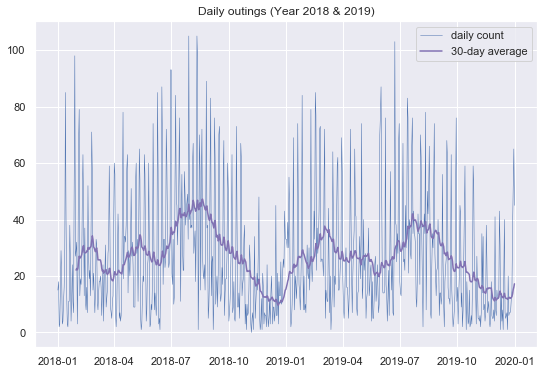

In [97]:
#When people goes more often outside?
df_outings_daily = d.groupby(pd.Grouper(key='date_start',freq='D')).count()
df_outings_daily['30D_avg']=df_outings_daily['document_id'].rolling(window=30,center=False).mean()

#Plot time series
sns.set()
f, ax = plt.subplots(figsize=(9, 6))
plt.plot(df_outings_daily['document_id'],linewidth=0.5,color='b',label='daily count')
plt.plot(df_outings_daily['30D_avg'],color='m',label='30-day average')
plt.title('Daily outings (Year 2018 & 2019)')
plt.legend()
plt.show()

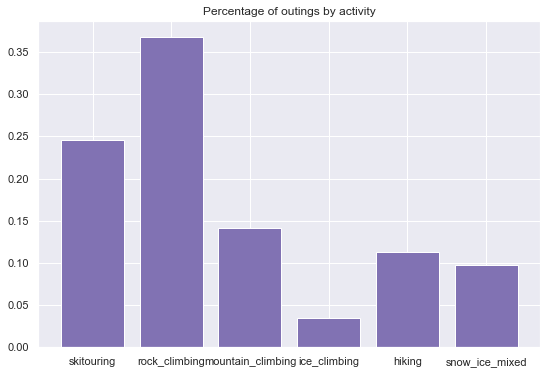

In [98]:
#Which are the most practiced sports in mountain among C2C contributors? - 
activities=['skitouring', 'rock_climbing','mountain_climbing','ice_climbing','hiking','snow_ice_mixed']
arr_activities  = np.sum(d[activities])
arr_activities_perc = (arr_activities/np.sum(arr_activities))

#Plot barplot
f, ax = plt.subplots(figsize=(9,6))
plt.bar(activities,arr_activities_perc,color='m')
plt.title('Percentage of outings by activity')
plt.show()

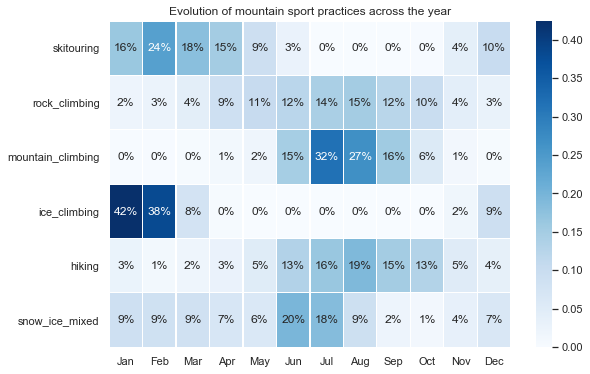

In [99]:
#When to practice which sport?

#Outings by month & activity
d['month']=d.date_start.dt.month
df_outings_month =d.groupby('month')[activities].sum()
df_outings_month[activities] = df_outings_month[activities].apply(lambda x: x/np.sum(x))
df_heatmap=df_outings_month.transpose()
df_heatmap.columns=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

#Plot heatmap - 
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(df_heatmap, annot=True, linewidths=.1, ax=ax,fmt=".0%",cmap='Blues')
plt.title("Evolution of mountain sport practices across the year")
plt.show()         

#Mountain sports practice type varies across the year due to conditions changes e.g. snow - 
#Are C2C contributors polyvalent acrosse several sports?

# EDA - Geospatial

In [150]:
import geoplot as gplt 

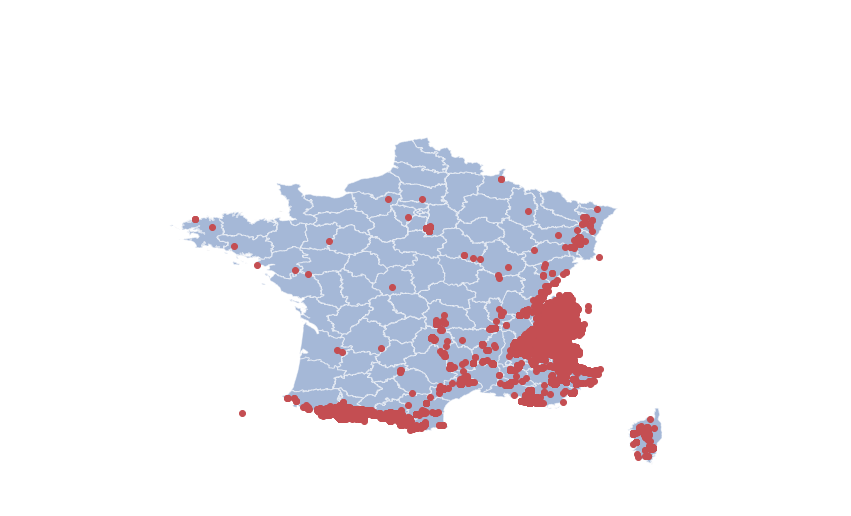

In [149]:
#Import coordinates - 
geo_coordinates=gpd.read_file('coordinates.shp')
geo_coordinates

#>>>Rajouter un ID pour pouvoir faire le lien avec le fichier csv - a minima


#Import French Map
french_map = gpd.read_file('departements-20140306-50m.shp')



#Plot French Map
fig,ax =plt.subplots(figsize=(15,15))
boundaries=[-10,15,40,55]

xlim=(boundaries[0],boundaries[1])
ylim=(boundaries[2],boundaries[3])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

french_map.plot(alpha=.5,ax=ax)
# gplt.polyplot(french_map,ax=ax)
ax.set_axis_off()


#plot
geo_coordinates.plot(ax=ax,marker='o',color='r')

#>>Formatting à travailler - 

#kde plot
# gplt.kdeplot(
#     geo_coordinates,
#     cmap='Reds',
#     shade=True, shade_lowest=False,
#     ax=ax
# )

plt.show()
#>>>Comment faire du zoom in sur la carte?

#>>>Récupérer un fond de carte

#Point visualization
# Ajaccio
# 41.918621
# 8.736870
# -0.127758

#Kernel density viz